## Notebooks Hub AlphaFold2 Tutorial Using Jupyter Widgets
This is an adapted notebook of the original [ColabFold AlphaFold2 notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) to serve as an example for Notebooks Hub using interactive Jupyter widgets.

Here are some helpful links to learn more about using AlphaFold and its impact in computational biology.  
&emsp; \- AlphaFold Protein Structure Database [FAQ](https://alphafold.ebi.ac.uk/faw)  
&emsp; \- neurosnap.ai's guides [Part 1](https://neurosnap.ai/blog/post/641a34a1148354cbab382afe) [Part 2](https://neurosnap.ai/blog/post/64222437a55063d26e9c069e) [Part 3](https://neurosnap.ai/blog/post/6422432aa55063d26e9c06a1)  
&emsp; \- Jumper et al (2021). Highly accurate protein structure prediction with AlphaFold. [doi: 10.1038/s41586-021-03819-2](https://doi.org/10.1038/s41586-021-03819-2)  
&emsp; \- Mirdita et al (2022). ColabFold: Making protein folding accessible to all. [doi: 10.1038/s41592-022-01488-1](https://doi.org/10.1038/s41592-022-01488-1)  
&emsp; \- Bertoline et al (2023). Before and after AlphaFold2: An overview of protein structure prediction. [doi: 10.3389/fbinf.2023.1120370](https://doi.org/10.3389/fbinf.2023.1120370)  
&emsp; \- Fang et al (2023). A method for multiple-sequence-alignment-free protein structure prediction using a protein language model. [doi: 10.1038/s42256-023-00721-6](https://doi.org/10.1038/s42256-023-00721-6)  

To learn more about Notebooks Hub or Jupyter Widgets, check out their documentation [here](https://polusai.github.io/notebooks-hub/) and [here](https://ipywidgets.readthedocs.io/en/8.1.2/index.html), respectively.

### Setup
Import appropriate packages into your program to get started. These are necessary to run the AlphaFold predictions later on.

In [1]:
import os
import re
import hashlib
import random
import shutil

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

The following packages will enable the build of interactive widgets to provide a better user experience. More information on building interactive widgets can be found in the [Jupyter Widgets documentation](https://ipywidgets.readthedocs.io/en/8.1.2/index.html).

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual, FileUpload, GridBox, Layout, VBox
import ipywidgets as widgets
from IPython.display import display, HTML
from ipyfilechooser import FileChooser

### Generate interactive widgets for query session inputs
An interactive widget will help the user select the necessary inputs that are required to run the analysis. Examples of additional styles and formats can be found in the [documentation's](https://ipywidgets.readthedocs.io/en/8.1.2/index.html) [widget list](https://ipywidgets.readthedocs.io/en/8.1.2/examples/Widget%20List.html).  
1. The core parameters to define before running AlphaFold predictions include the **query sequence(s)**, **Amber relaxed model(s)**, and **template(s)**, as well as **jobname** to keep track of each query session.  
2. Set up individual widget types for each prediction parameter. These are widget *children* that will be grouped into a *family* in the next step. For visual convenience, a border will be added to outline each family container.

The `.HTML` widget type will display text that can be used as headers or descriptions. These strings can be formatted using html tags (e.g., `<b>`). The `grid_area` attribute will help with widget placement inside the family container.

In [3]:
html_input = widgets.HTML(description="<b>Input Protein Sequences:</b>",
                          value="",
                          style={'description_width': 'initial'},
                          layout=Layout(width='auto', grid_area='html_input'))

Variables can be assigned values (or, as shown below, concatenated f-strings for large blocks of text) that can then be used to more easily attribute values inside each widget.

In [4]:
qtips = (f"<b>Helpful Tips</b><br>"
         f"<b>Query:</b> Use `:` to specify inter-protein chainbreaks for modeling complexes (supports homo- and hetro-oligomers). "
         f"For example `PI...SK:PI...SK` for a homodimer. <br>"
         f"<b>Template Mode:</b> Select the desired template to run predictions against. <br>"
         f"<b>Amber Relaxes:</b> Specify how many of the top ranked structures to relax using Amber. <br>"
         f"<u><a href=https://ambermd.org/>Amber`</a></u> is a suite of programs that apply AMBER forcefields to simulations of biomolecules and molecular dynamics. "
         f"Amber relaxed models relax acid side chain positions and are usually required for users who need accurate side-chain positions."
        )

html_qtips = widgets.HTML(description="",
                          value=qtips,
                          style={'description_width': 'initial'},
                          layout=Layout(width='auto', grid_area='html_qtips'))

The `.Text` widget type will provide a box that allows the user to input text strings while `.Textarea` will provide an adjustable box. In this case, the adjustable box was selected for **query sequence**. This will be useful if the query is long or complex, because the user can view the input query in its entirety. If specified, the attribute `placeholder` will be visible in the text box when empty. An initial value can be assigned to the `value` attribute to pre-populate the box.

In [5]:
text_queryseq = widgets.Textarea(value='PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK',
                                 placeholder='Input Amino Acid Sequence for Protein of Interest',
                                 description='Query Sequence:',
                                 disabled=False,
                                 style={'description_width': '170px'},
                                 layout=Layout(width='700px', grid_area='text_queryseq'))

text_jobname = widgets.Text(value='test',
                            placeholder='Type Jobname',
                            description='Jobname:',
                            disabled=False,
                            style={'description_width': '170px'},
                            layout=Layout(width='auto', grid_area='text_jobname'))

The next two widgets need to offer pre-determined options for user selection. These options can be defined for each necessary parameters using the `options` attribute within each appropriate individual. The default selection within these options can be specified using the `value` attribute.  

The `RadioButtons` widget type will list the possible options with buttons for a single selection.

In [6]:
buttons_num_relax = widgets.RadioButtons(options=[('0',0),('1',1),('5',5)],
                                         value=0,
                                         description='Number of Amber Relaxes:',
                                         disabled=False,
                                         style={'description_width': '170px'},
                                         layout=Layout(width='auto', grid_area='buttons_num_relax'))

The `.ToggleButtons` widget will display buttons that allow the user to make one choice of the given options. This widget type is very helpful, because the attribute `tooltips` enables descriptions for each option upon hovering over with the mouse pointer.

In [7]:
buttons_template_mode = widgets.ToggleButtons(options=['none','pdb100','custom'],
                                              description='Template Mode:',
                                              disabled=False,
                                              button_style='',
                                              style={'description_width': '170px'},
                                              layout=Layout(width='auto', grid_area='buttons_template_mode'),
                                              tooltips=['no template information is used',
                                                        'detect templates in pdb100',
                                                        'upload and search own templates (PDB or mmCIF format, see notes) to bias AlphaFold\'s predictions'])

Now, set up the widget family. Jupyter's `Box` widgets utilize the CSS [flexbox spec](https://css-tricks.com/snippets/css/a-guide-to-flexbox/) for gathering individual widgets within a container. The family below will use the `GridBox` container that can be customized according to the CSS [Grid layouts](https://css-tricks.com/snippets/css/complete-guide-grid).  
1. Using the `GridBox` container, define its children from the code above.
2. Lay out children as desired within container. Each child's `Layout.grid_area` attribute will need to have a matching label inside the container's `Layout.grid_template_areas` attribute.
3. `display()` will display the interactive widget family.

In [8]:
controls_query = GridBox(children=[html_input, html_qtips, text_queryseq, text_jobname, buttons_num_relax, buttons_template_mode],
                         layout=Layout(
                             border='solid 1.5px',
                             width='1255px',
                             grid_template_rows='auto auto auto auto auto',
                             grid_template_columns='300px 450px 500px',
                             grid_template_areas='''
                             "html_input html_input html_qtips"
                             "text_queryseq text_queryseq html_qtips"
                             "text_jobname . html_qtips"
                             "buttons_template_mode buttons_template_mode html_qtips"
                             "buttons_num_relax buttons_num_relax html_qtips"
                             ''')
                        )

display(controls_query)

GridBox(children=(HTML(value='', description='<b>Input Protein Sequences:</b>', layout=Layout(grid_area='html_…

### Access widget outputs to generate a new directory for saving prediction results and queries

The following code defines functions to help augment jobnames to minimize the risk of files being overwritten if the same sequence was queried multiple times using different parameter values. The functions below will append an underscore and integer at the end of the jobname with each sequential run (e.g., `_0`, `_1`, ...).

In [9]:
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

def update_jobname(jobname):
    basejobname = "".join(jobname.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname_new = add_hash(basejobname, query_sequence)
    
    return jobname_new

User-defined and selected values from the widget can be accessed through each children's `.value` to save as accessible variables. This is shown in the top portion of the following code block.  
&emsp; &bull; With the rest of the code block, the system will then check in the working path for a directory sharing the same jobname. If one does not exist, it will create one. If one does, it will create an iteration (e.g., `_0`, `_1`, ...).   
&emsp; &bull; ***Note:*** *these code chunks are required to be in the same cell, otherwise iterative numbering does not work as intended (i.e., recursively appends `_0` instead of increasing in value).*

In [10]:
# save outputs as accessible variables
jobname = text_jobname.value
query_sequence = text_queryseq.value
num_relax = buttons_num_relax.value
template_mode = buttons_template_mode.value

use_amber = num_relax > 0
length = len(query_sequence.replace(":",""))

# remove whitespaces and update jobname
query_sequence = "".join(query_sequence.split())
jobname = update_jobname(jobname)

# check if directory with jobname exists
def check(folder):
    if os.path.exists(folder):
        return False
    else:
        return True
    
if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"): n += 1
    jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save a copy of the query sequence in the newly generated folder
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# for verification purposes, return the session's information.
print(f"jobname: {jobname}" "\n"
     f"sequence: {query_sequence}" "\n"
      f"length: {length}" "\n"
      f"relax: {num_relax}" "\n"
      f"template: {template_mode}")

jobname: test_a5e17_3
sequence: PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length: 59
relax: 0
template: none


### Generate file upload widgets to select custom templates for predictions

**Local File Upload:** The `FileUpload` widget allows the user to select local computer files for upload to the current working directory on the server. AlphaFold allows for multiple custom templates, so `multiple=TRUE` was set. *One* specific file extension can be specified inside the attribute `accept=''`.   
&emsp; &bull; ***Note:*** *This will replace pre-existing files in the current directory with the same name. Please rename if necessary.*  
&emsp; &bull; ***Note:*** *The counter shown will increase despite re-selecting a file. The cell containing `display(upload)` must be rerun to reset the counter.*  

In [11]:
upload = FileUpload(accept='', multiple=True)

**Server File Upload:** The `FileChooser` widget allows the user to select a single file that is already present on the server. Default files can be shown by defining `fc.filter_pattern` with one or more specific extensions. For AlphaFold, templates should be PDB or PDBx/mmCIF format.  
&emsp; &bull; **Note:** ipyfilechooser is a separate package that works in conjunction with ipywidgets.  
&emsp; &bull; If a file from the server was selected, `os.rename` will move the file into the template folder inside the current query session's directory (i.e., */\<jobname>/template/\<filename>*)  
&emsp; &bull; If a file from the server was selected, `os.rename` will move the file into the template folder inside the current query session's directory (i.e., */\<jobname>/template/\<filename>*)  

In [12]:
fc = FileChooser(
    os.getcwd(),
    filename='',
    title='<b>Select custom template(s)</b><br>Note: must follow four letter PDB naming with lower case letters',
    show_hidden=False,
    select_default=False,
    show_only_dirs=False
    )

fc.filter_pattern = ['*.pdb', '*.pdbx', '*.txt'] 

The following statements set variables for downstream analysis and will display the upload widgets only if the `template_mode` was set to *custom*. A template folder will also be generated inside the current jobname's directory to store template files.  
&emsp; &bull; ***Note:*** *In order to cancel file selection from the server, the previous cell must be rerun.*

In [13]:
# set variables and display file uploaders if template mode is set to custom
if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
elif template_mode == "custom":
    custom_template_path = os.path.join(jobname,f"template")
    os.makedirs(custom_template_path, exist_ok=True)
    use_templates = True
    display(fc)
    display(upload)
else:
    custom_template_path = None
    use_templates = False

In [14]:
# move server file to session's template folder
if template_mode == "custom":
    if fc.selected is not None:
        for fn in fc.selected:
            os.rename(fn,os.path.join(custom_template_path,fn))

# return filenames of all files selected for custom template use.
if not upload.value:
    fps = "None"
print(f"File selected from the server: {fc.selected}")
print(f"File(s) selected from the local host for upload: {fps}")

# upload local files to server and place inside session's template folder
if upload.value:
    fps = []
    for fp in upload.value:
        fps.append(f"{fp}")
        with open(fp, 'wb') as output_file:
                content = upload.value[fp]['content']
                output_file.write(content)
                os.rename(fp,os.path.join(custom_template_path,fp))
        print(f">> {fp} successfully uploaded")



File selected from the server: None
File(s) selected from the local host for upload: None


### Generate interactive widget for multiple sequence alignment options

AlphaFold's AI was trained with multiple sequence alignment (MSA), paired residues, and experimentally validated protein structures from the [RSCB Protein Data Bank (PDB)](https://www.rcsb.org/). AlphaFold2 uses MMseq2 [(Many-against-Many searching)](https://mmseqs.com/latest/userguide.pdf) software to search and cluster huge sequence sets from databases that comprise of UniRef [(UniProt Reference Clusters)](https://www.uniprot.org/help/uniref) and its own novel [environmental database](https://colabfold.mmseqs.com/), referred to as _env_ inside widget options. MSA pairing can also be controlled to improve prediction accuracy for protein complexes. A new family of widgets will be created below for these options.

Use the `.HTML` widget type to create a descriptive header.

In [16]:
html_msaopts = widgets.HTML(description="<b>Multiple Sequence Alignment Options (custom MSA upload, single sequence, pairing mode)</b>",
                            value="",
                            style= {'description_width': 'initial'},
                            layout=Layout(width='auto', grid_area='html_msaopts'),)

The `.Select` widget type will display a box with all possible options for selection by row.

In [17]:
select_msa_mode = widgets.Select(options=['mmseqs2_uniref_env', 'mmseqs2_uniref', 'single_sequence', 'custom'],
                                 value='mmseqs2_uniref_env',
                                 description='MSA mode:',
                                 rows=5,
                                 disabled=False,
                                 layout=Layout(width='auto', grid_area='select_msa_mode'))

The `.ToggleButtons` type will display options with the helpful description upon hover.

In [18]:
buttons_pair_mode = widgets.ToggleButtons(options=['unpaired_paired', 'paired', 'unpaired'],
                                          description='Pair Mode:',
                                          disabled=False,
                                          button_style='',
                                          layout=Layout(width='auto', grid_area='buttons_pair_mode'),
                                          tooltips=['pair sequences from same species + unpaired MSA',
                                                    'seperate MSA for each chain',
                                                    'only use paired sequences'])

Now, set up the widget family.
1. Using the `GridBox` container, define its children from the code above.
2. `display()` will display the interactive widget family.

In [19]:
controls_msa = GridBox(children=[html_msaopts, select_msa_mode, buttons_pair_mode],
                       layout=Layout(
                           border='solid 1.5px',
                           width='605px',
                           grid_template_rows='auto auto',
                           grid_template_columns='300px 300px',
                           grid_template_areas='''
                           "html_msaopts html_msaopts"
                           "select_msa_mode buttons_pair_mode"
                           ''')
                      )

display(controls_msa)

GridBox(children=(HTML(value='', description='<b>Multiple Sequence Alignment Options (custom MSA upload, singl…

Next, save the widget selections as accessible variables.

In [20]:
msa_mode = select_msa_mode.value
pair_mode = buttons_pair_mode.value

#### Custom MSA file (.a3m formatted)
##### DISCLAIMER: HAVE NOT TESTED FUNCTIONALITY OF USING CUSTOM A3M FILE AFTER SUCCESSFUL UPLOAD
Custom MSA allows users to provide their own alignment files for multiple sequence alignment. Any kind of alignment tool can be used to generate the MSA, including the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits).

In [21]:
# create additional file uploaders to use for custom MSA
upload_msa = FileUpload(accept='.a3m', multiple=False)

# decide which a3m to use
if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
    a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
    if not os.path.isfile(a3m_file):
        print("The first FASTA entry of the A3M file must be the query sequence without gaps.")
        display(upload_msa)
else:
    a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

The following code cell will save the selected local file to the server and create a renamed copy for the program to access.

In [22]:
# upload local file to session's folder on server
if upload_msa.value:
    up_msa = upload_msa.value
    fpmsa = []
    for fn, fd in up_msa.items():
        fpmsa.append(f"{fn}")
        with open(fn, 'wb') as output_file:
            content = fd['content']
            output_file.write(content)
            os.rename(fn,os.path.join(jobname,fn))
        print(f"{fn} successfully uploaded. Don't forget to cite your custom MSA generation method!")

if upload_msa.value:
    orig_msa = f"{jobname}/{fpmsa[0]}"
    custom_msa = shutil.copy2(orig_msa,f"{jobname}/strip_{fpmsa[0]}") # copy file as backup or for preservation purposes

    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=True):
        if line.startswith(">"):
            header = header + 1
        if not line.rstrip():
            continue
        if line.startswith(">") == False and header == 1:
            query_sequence = line.rstrip()
        print(line, end='')
        
    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"Moving {custom_msa} to {a3m_file} for use by AlphaFold.")

### Advanced Settings

Create the widget header and a tips box using the `.HTML` widget type.

In [23]:
html_advset = widgets.HTML(description="<b>Advanced Settings:</b>",
                           value="",
                           style={'description_width': 'initial'},
                           layout=Layout(width='auto', grid_area='html_advset'))

advtips = (f"<b>Helpful Tips</b><br>"
         f"<b>Model Type:</b> Choose the structural dimentions for prediction (i.e., oligomeric or multimeric). For monomer predictions, choose alphafold2-ptm. "
         f"Auto permits the model to decide and will use alphafold2_multimer_v3 for complex prediction. <br>"
         f"<b>Number of Recycles:</b> Enables multiple reiterations through the sequence by building off its own predictions. "
         f"The default is 3, but 6+ will enable a more accurate prediction despite longer runtimes. <br>"
         f"<b>Recycle Early Stop Tolerance:</b> Auto tolerance will be 0.0, unless using alphafold2_multimer_v3. <br>"
         f"<b>Alphafold2_multimer_v3:</b> For complex predictions using this model, `auto` will result in recycles = 20 and tolerance = 0.05."
        )

html_advtips = widgets.HTML(description="",
                          value=advtips,
                          style={'description_width': 'initial'},
                          layout=Layout(width='auto', grid_area='html_advtips'))

The `.Dropdown` widget type will display a single selection list in dropdown format. Create dropdown widgets to select AlphaFold **model types**, **number of recycles**, and **recycle early stop tolerance** values.

In [24]:
drop_model_type = widgets.Dropdown(options=['auto','alphafold2_ptm','alphafold2_multimer_v1','alphafold2_multimer_v2','alphafold2_multimer_v3'],
                                   value='auto',
                                   description='Model Type:',
                                   disabled=False,
                                   style={'description_width': '170px'},
                                   layout=Layout(width='auto', grid_area='drop_model_type'))

drop_num_recycles = widgets.Dropdown(options=[('auto','auto'),('0',0),('1',1),('3',3),('6',6),('12',12),('24',24),('48',48)],
                                     value='auto',
                                     description='Number of Recycles:',
                                     disabled=False,
                                     style={'description_width': '170px'},
                                     layout=Layout(width='auto', grid_area='drop_num_recycles'))

drop_tol = widgets.Dropdown(options=[('auto','auto'),('0.0',0.0),('0.5',0.5),('1.0',1.0)],
                            value='auto',
                            description='Recycle Early Stop Tolerance:',
                            disabled=False,
                            style={'description_width': '170px'},
                            layout=Layout(width='auto', grid_area='drop_tol'))

Use `.ToggleButtons` to create toggle buttons to select **pairing strategy** and have descriptions display upon hovering over each button.

In [25]:
buttons_pairing_strategy = widgets.ToggleButtons(options=['greedy','complete'],
                                                 description='Pairing Strategy:',
                                                 disabled=False,
                                                 button_style='',
                                                 style={'description_width': '170px'},
                                                 layout=Layout(width='auto', grid_area='buttons_pairing_strategy'),
                                                 tooltips=['pair any taxonomically matching subsets',
                                                           ' all sequences have to match in one line'])

Now, set up the widget family, once again using `GridBox` and `display()`.

In [26]:
controls_advset = GridBox(children=[html_advset, html_advtips, drop_model_type, drop_num_recycles, drop_tol, buttons_pairing_strategy],
                          layout=Layout(
                              border='solid 1.5px',
                              width='1305px',
                              grid_template_rows='auto auto auto auto auto',
                              grid_template_columns='350px 200px 750px',
                              grid_template_areas='''
                              "html_advset html_advset html_advtips"
                              "drop_model_type . html_advtips"
                              "drop_num_recycles  . html_advtips"
                              "drop_tol . html_advtips"
                              "buttons_pairing_strategy buttons_pairing_strategy html_advtips"
                              ''')
                         )

display(controls_advset)

GridBox(children=(HTML(value='', description='<b>Advanced Settings:</b>', layout=Layout(grid_area='html_advset…

Lastly, save the widget selections as accessible variables.

In [27]:
model_type = drop_model_type.value
pairing_strategy = buttons_pairing_strategy.value

if drop_model_type.value != 'alphafold2_multimer_v3':
    if drop_num_recycles.value == 'auto':
        num_recycles = 3
    else:
        num_recycles = drop_num_recycles.value
        
    if drop_tol.value == 'auto':
        recycle_early_stop_tolerance = 0.0
    else:
        recycle_early_stop_tolerance = drop_tol.value

elif drop_model_type.value == 'alphafold2_multimer_v3':
    if drop_num_recycles.value == 'auto':
        num_recycles = 20
    else:
        num_recycles = drop_num_recycles.value

    if drop_tol.value == 'auto':
        recycle_early_stop_tolerance = 0.5
    else:
        recycle_early_stop_tolerance = drop_tol.value

### Generate interactive widget to define sample settings

`.HTML` widgets can be used again to add headers as well as additional text to provide setting tips.

In [28]:
html_sampset = widgets.HTML(description="<b>Sample Settings:</b>",
                            value="",
                            style= {'description_width': 'initial'})

msatips = (f"<b>Helpful Tips</b><br>"
         f"- Decrease Max MSA to increase uncertainty.<br>"
         f"- Enable dropouts and increase # seeds to sample predictions from uncertainty of the model."
        )

html_msatips = widgets.HTML(description="",
                          value=msatips,
                          style={'description_width': 'initial'},
                          layout=Layout(width='auto', grid_area='html_msatips'))

A `.SelectionSlider` widget will be used alongside the standard `.Dropdown` type used previously. The selection slider offers a range of custom values without conforming to a uniform increment.

In [29]:
drop_max_msa = widgets.Dropdown(options=['auto','512:1024','256:512','64:128','32:64', '16:32'],
                                value='auto',
                                description='Max MSA:',
                                disabled=False)

slider_num_seeds = widgets.SelectionSlider(options=[('1',1),('2',2),('4',4),('8',8),('16',16)],
                                           value=1,
                                           description='# seeds:',
                                           disabled=False)

Here, a `.Checkbox` widget type that can be selected or unselected is introduced.

In [30]:
cb_dropout = widgets.Checkbox(value=False, description='Use Dropout', disabled=False, indent=True)

Now, set up the widget family, once again using `GridBox` and `display()`.

In [31]:
controls_sampset = GridBox(children=[html_sampset, html_msatips, drop_max_msa, slider_num_seeds, cb_dropout],
                           layout=Layout(
                               border='solid 1.5px',
                               width='805px',
                               grid_template_rows='auto auto auto auto auto',
                               grid_template_columns='400px 400px',
                               grid_template_areas='''
                               "h_sampset html_msatips"
                               "drop_max_msa html_msatips"
                               "slider_num_seeds html_msatips"
                               "cb_dropout ."
                               ''')
                          )

display(controls_sampset)

GridBox(children=(HTML(value='', description='<b>Sample Settings:</b>', style=DescriptionStyle(description_wid…

Save the widget selections as accessible variables. These will also be used to assign other values as depicted in the bottom half of the code cell.

In [32]:
max_msa = drop_max_msa.value
num_seeds = slider_num_seeds.value
use_dropout = cb_dropout.value

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

### Generate interactive widget to toggle save settings

The `.IntText` widget can be used to allow the user to specify any integer inside its given text box.

In [33]:
text_save_dpi = widgets.IntText(value=200,
                                description='dpi:',
                                disabled=False,
                                layout=Layout(width='auto', grid_area='text_save_dpi'))

Set up individual `.HTML` widgets to display text and `.Checkboxes` for toggles.

In [34]:
html_saveset = widgets.HTML(description="<b>Save Settings:</b>",
                            value="",
                            style= {'description_width': 'initial'},
                            layout=Layout(width='auto', grid_area='html_saveset'))

html_savedpi = widgets.HTML(description="Set dpi for image resolution:",
                            value="",
                            style= {'description_width': 'initial'},
                            layout=Layout(width='auto', grid_area='html_savedpi'))

cb_savefull = widgets.Checkbox(value=False,description='Save All', disabled=False, layout=Layout(width='auto', grid_area='cb_savefull'))

cb_saverecyc = widgets.Checkbox(value=False, description='Save Recycles', disabled=False, layout=Layout(width='auto', grid_area='cb_saverecyc'))

Set up the widget family, once again using `GridBox` and `display()`. This time columns are also utilized. For proper layout assignment into the family container, `grid_area` was defined for each widget child.

In [35]:
controls_saveset = GridBox(children=[html_saveset, html_savedpi, text_save_dpi, cb_savefull, cb_saverecyc],
                           layout=Layout(
                               border='solid 1.5px',
                               width='455px',
                               grid_template_rows='auto auto auto auto',
                               grid_template_columns='150px 300px',
                               grid_template_areas='''
                               "html_saveset ."
                               "html_savedpi text_save_dpi"
                               ". cb_savefull"
                               ". cb_saverecyc"
                               ''')
                          )

display(controls_saveset)

GridBox(children=(HTML(value='', description='<b>Save Settings:</b>', layout=Layout(grid_area='html_saveset', …

Save the widget selections as accessible variables. 

In [36]:
save_all = cb_savefull.value
save_recycles = cb_saverecyc.value
dpi = text_save_dpi.value

### Prepare prediction run

Use a simple `.Checkbox` widget to allow the user to toggle whether or not images should be displayed during the prediction run.

In [37]:
cb_displayimg = widgets.Checkbox(value=True, description='Display Images', disabled=False, indent=True, layout=Layout(border='solid 1.5px'))
display(cb_displayimg)

Checkbox(value=True, description='Display Images', layout=Layout(border='solid 1.5px'))

Assign the selection as an accessible variable.

In [38]:
display_images = cb_displayimg

The following package imports are necessary to finally run the structural predictions.

In [39]:
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
#warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

from colabfold.colabfold import plot_protein
#from colabfold.cf import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

import os
import numpy as np

Add system paths to the new dependencies that were installed previously.

In [40]:
# pdbfixer 1.8.1
if use_amber and f"/opt/conda/pkgs/pdbfixer-1.8.1-pyh6c4a22f_0/site-packages/" not in sys.path:
    sys.path.insert(0, f"/opt/conda/pkgs/pdbfixer-1.8.1-pyh6c4a22f_0/site-packages/")

# openmm 7.7.0
if use_amber and f"/opt/conda/pkgs/openmm-7.7.0-py39h15fbce5_1/lib/python3.9/site-packages" not in sys.path:
    sys.path.insert(0, f"/opt/conda/pkgs/openmm-7.7.0-py39h15fbce5_1/lib/python3.9/site-packages")

# kalign2 2.0.4
if use_templates and f"/opt/conda/pkgs/kalign2-2.04-h031d066_5/bin" not in sys.path:
    sys.path.insert(0, f"/opt/conda/pkgs/kalign2-2.04-h031d066_5/bin")

# hhsuite 3.3.0
if use_templates and f"/opt/conda/pkgs/hhsuite-3.3.0-py39pl5321he10ea66_9/bin" not in sys.path:
    sys.path.insert(0, f"/opt/conda/pkgs/hhsuite-3.3.0-py39pl5321he10ea66_9/bin")

Additionally, the following cell defines a few necessary functions for ColabFold/AlphaFold.

In [41]:
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed:
        if display_images:
            fig = plot_protein(protein_obj, Ls=length, dpi=150)
            plt.show()
            plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
    setup_logging(Path(log_filename))
    logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
    use_cluster_profile = False
else:
    use_cluster_profile = True

### Run AlphaFold2 predictions

**Note:** IF USING AMBER RELAXATION: User may receive the following error during pLDDT reranking and may be unable to continue forward. Adding `run_relax=false` somewhere inside may help with this issue [see here](https://github.com/google-deepmind/alphafold/issues/112).  
> ValueError: Minimization failed after 100 attempts.

2023-12-05 20:28:49,371 Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-12-05 20:28:49,374 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-12-05 20:28:49,379 Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-12-05 20:28:49,383 No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-12-05 20:28:49,383 WARNING: no GPU detected, will be using CPU
2023-12-05 20:28:59,023 Found 4 citations for tools or databases
2023-12-05 20:28:59,024 Query 1/1: test_a5e17_3 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


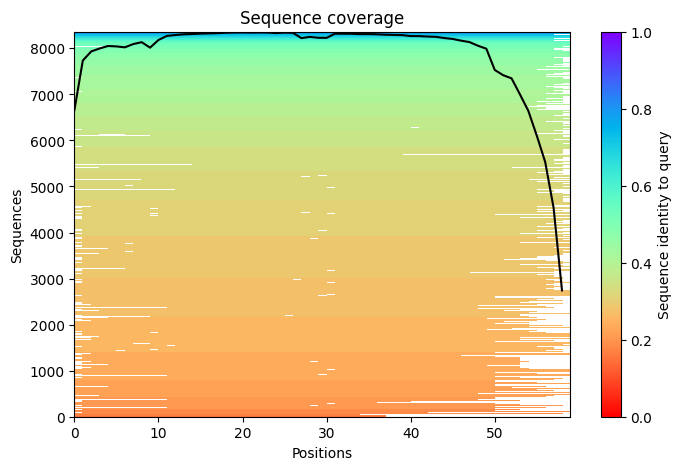

2023-12-05 20:29:02,320 Setting max_seq=512, max_extra_seq=5120


2023-12-05 20:29:15.291663: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43410312 exceeds 10% of free system memory.
2023-12-05 20:29:15.297120: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42604372 exceeds 10% of free system memory.
2023-12-05 20:29:15.920536: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42604372 exceeds 10% of free system memory.
2023-12-05 20:29:16.028863: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42604372 exceeds 10% of free system memory.
2023-12-05 20:29:16.135384: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 42604372 exceeds 10% of free system memory.


2023-12-05 20:32:33,551 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.6 pTM=0.754
2023-12-05 20:35:27,454 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.5 pTM=0.758 tol=0.233
2023-12-05 20:38:21,705 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.4 pTM=0.757 tol=0.0374
2023-12-05 20:41:15,995 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96.1 pTM=0.756 tol=0.0339
2023-12-05 20:41:15,997 alphafold2_ptm_model_1_seed_000 took 719.7s (3 recycles)


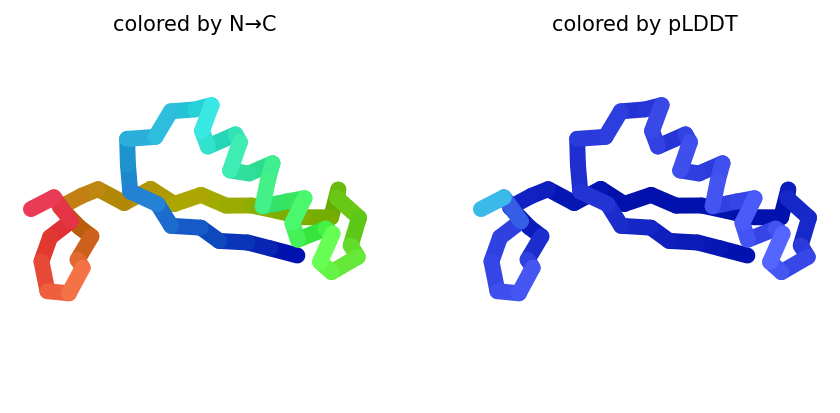

2023-12-05 20:44:09,965 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=96.9 pTM=0.76
2023-12-05 20:47:03,429 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=96.9 pTM=0.765 tol=0.284
2023-12-05 20:49:57,554 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=96.9 pTM=0.766 tol=0.124
2023-12-05 20:52:50,860 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.8 pTM=0.767 tol=0.0565
2023-12-05 20:52:50,862 alphafold2_ptm_model_2_seed_000 took 694.4s (3 recycles)


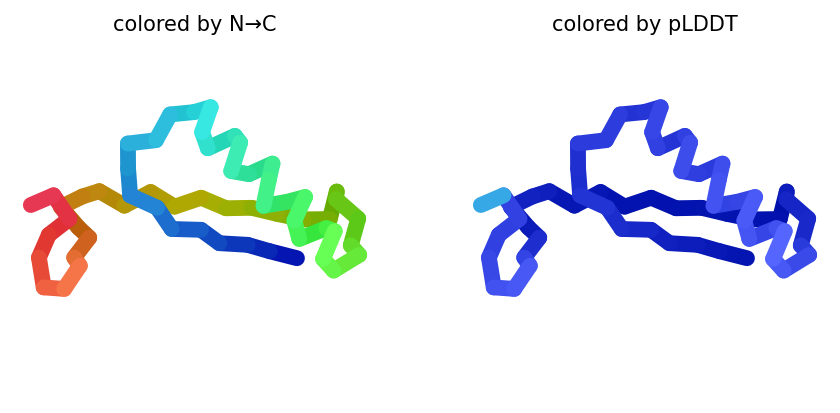

2023-12-05 20:55:44,737 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.775
2023-12-05 20:58:38,388 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.783 tol=0.273
2023-12-05 21:01:32,093 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.4 pTM=0.782 tol=0.116
2023-12-05 21:04:25,697 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.4 pTM=0.784 tol=0.0477
2023-12-05 21:04:25,699 alphafold2_ptm_model_3_seed_000 took 694.7s (3 recycles)


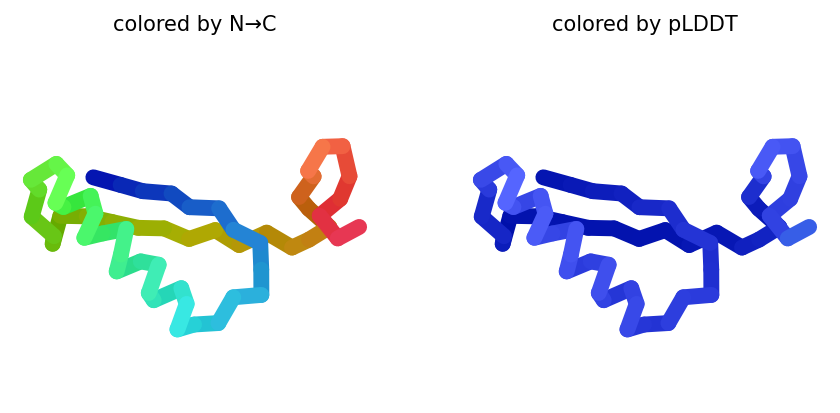

2023-12-05 21:07:19,449 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.4 pTM=0.774
2023-12-05 21:10:12,890 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.4 pTM=0.781 tol=0.302
2023-12-05 21:13:06,725 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.2 pTM=0.777 tol=0.0837
2023-12-05 21:16:00,285 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=96.9 pTM=0.777 tol=0.033
2023-12-05 21:16:00,287 alphafold2_ptm_model_4_seed_000 took 694.5s (3 recycles)


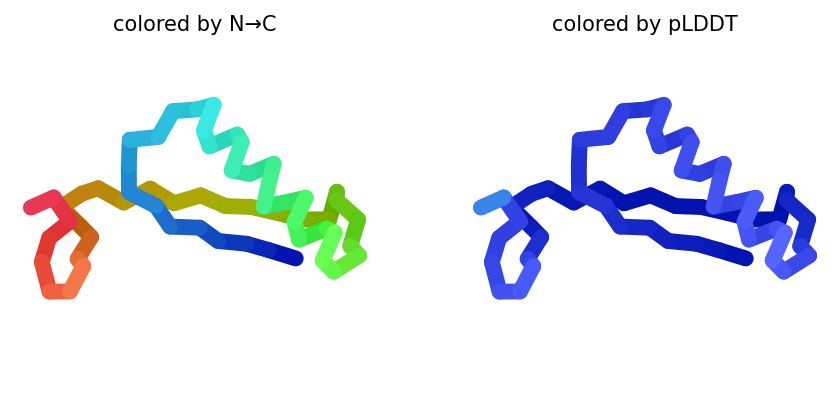

2023-12-05 21:18:54,305 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.4 pTM=0.784
2023-12-05 21:21:47,797 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.9 pTM=0.784 tol=0.248
2023-12-05 21:24:41,418 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.3 pTM=0.776 tol=0.188
2023-12-05 21:27:35,677 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.3 pTM=0.778 tol=0.0931
2023-12-05 21:27:35,679 alphafold2_ptm_model_5_seed_000 took 695.2s (3 recycles)


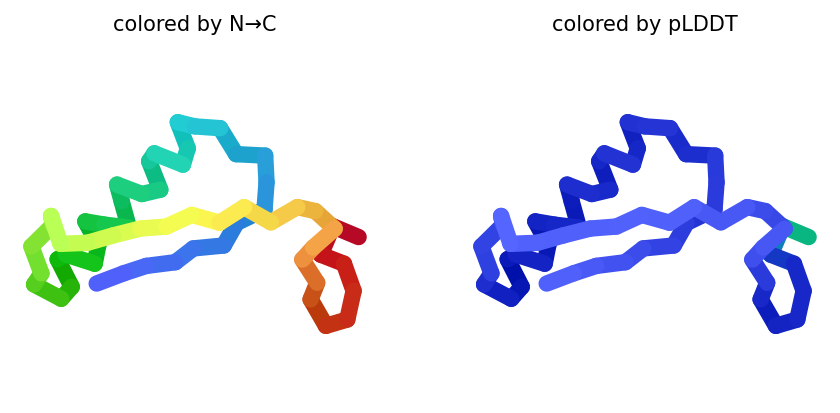

2023-12-05 21:27:35,815 reranking models by 'plddt' metric
2023-12-05 21:27:35,816 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.784
2023-12-05 21:27:35,828 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=96.9 pTM=0.777
2023-12-05 21:27:35,837 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=96.8 pTM=0.767
2023-12-05 21:27:35,846 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.3 pTM=0.778
2023-12-05 21:27:35,852 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=96.1 pTM=0.756
2023-12-05 21:27:38,005 Done


In [42]:
download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)

Once predictions are successfully generated, the results can be saved into the current directory as a zip file.

In [43]:
results = f"{jobname}.result"

if not check(f"{results}.zip"):
    n = 0
    while not check(f"{results}_{n}.zip"): n += 1
    results = f"{results}_{n}"
    
shutil.make_archive(results, 'zip', jobname)

'/home/jovyan/work/AF2 preinstall test/test_a5e17_3.result.zip'

**Result zip file contents**  
1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

### Generate interactive widget to display 3D structure

Import additional packages to enable visualization in 3D.  
**Note:** *`colabfold.colabfold.py` was renamed to `colabfold.cf.py` directly inside the package contents, and `colabfold.colabfold` was renamed to `colabfold.cf` in the next cell and inside `colabfold.batch.py`.*

In [45]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

Generate an interactive widget to select which ranked prediction to display, which specific color scheme, and whether to show sidechains and/or mainchains. The same widget types used earlier (`.HTML`, `.Dropdown`, `.Select`, `.Checkbox`) will be used for this family.  

***Note:*** *this will not update the 3D image in real time, so each time a different selection is selected, the cell containing the following functions will need to be rerun.*  
&emsp; &emsp; `show_pdb(rank_num, show_sidechains, show_mainchains, color).show()`  
&emsp; &emsp; `if color == "pLDDT": plot_plddt_legend().show()`

In [46]:
html_disp3d = widgets.HTML(description="<b>Display 3D Structure:</b>",
                           value="",
                           style= {'description_width': 'initial'},
                           layout=Layout(width='auto', grid_area='html_disp3d'))

drop_rank_num = widgets.Dropdown(options=[('1',1),('2',2),('3',3),('4',4),('5',5)],
                                 value=1,
                                 description='rank_num:',
                                 disabled=False,
                                 layout=Layout(width='auto', grid_area='drop_rank_num'))

select_color = widgets.Select(options=['chain','pLDDT','rainbow'],
                              value='pLDDT',
                              description='Color:',
                              rows=3,
                              disabled=False,
                              layout=Layout(width='auto', grid_area='select_color'))

cb_sidechains = widgets.Checkbox(value=False,
                                 description='show_sidechains',
                                 disabled=False,
                                 indent=True,
                                 layout=Layout(width='auto', grid_area='cb_sidechains'))

cb_mainchains = widgets.Checkbox(value=False,
                                 description='show_mainchains',
                                 disabled=False,
                                 indent=True,
                                 layout=Layout(width='auto', grid_area='cb_mainchains'))

Display widget family.

In [47]:
controls_disp3d = GridBox(children=[html_disp3d, drop_rank_num, select_color, cb_sidechains, cb_mainchains],
                          layout=Layout(
                              border='solid 1.5px',
                              grid_template_rows='auto auto',
                              grid_template_columns='20% 20% 20%',
                              grid_template_areas='''
                              "html_disp3d html_disp3d ."
                              "drop_rank_num select_color cb_sidechains"
                              ". select_color cb_mainchains"
                              ''')
                         )

display(controls_disp3d)

GridBox(children=(HTML(value='', description='<b>Display 3D Structure:</b>', layout=Layout(grid_area='html_dis…

The following code cell helps apply the proper display settings for the predicted protein structure selected in the widget.

In [48]:
def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="pLDDT"):
    model_name = f"rank_{rank_num}"
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
    #view.addModel(open(pdb_file[0],'r').read(),'pdb')
    view.addModel(open(pdb_file[rank_num -1],'r').read(),'pdb')

    if color == "pLDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
                chains = len(queries[0][1]) + 1 if is_complex else 1
                for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
                    view.setStyle({'chain':chain},{'cartoon': {'color':color}})

    if show_sidechains:
        BB = ['C','O','N']
        view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                      {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                      {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                      {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    if show_mainchains:
        BB = ['C','O','N','CA']
        view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

    view.zoomTo()
    return view

Assign widget selections as accessible variables and show 3D protein structure.

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

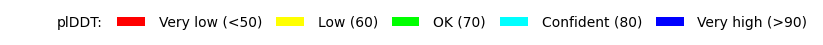

In [49]:
rank_num = drop_rank_num.value
color = select_color.value
show_sidechains = cb_sidechains.value
show_mainchains = cb_mainchains.value

jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_file = sorted(glob.glob(f"./{jobname}"+"/*.pdb"))

# show result
show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "pLDDT":
    plot_plddt_legend().show()

##### Plots

Generate master plot of mini plots generated from the prediction.


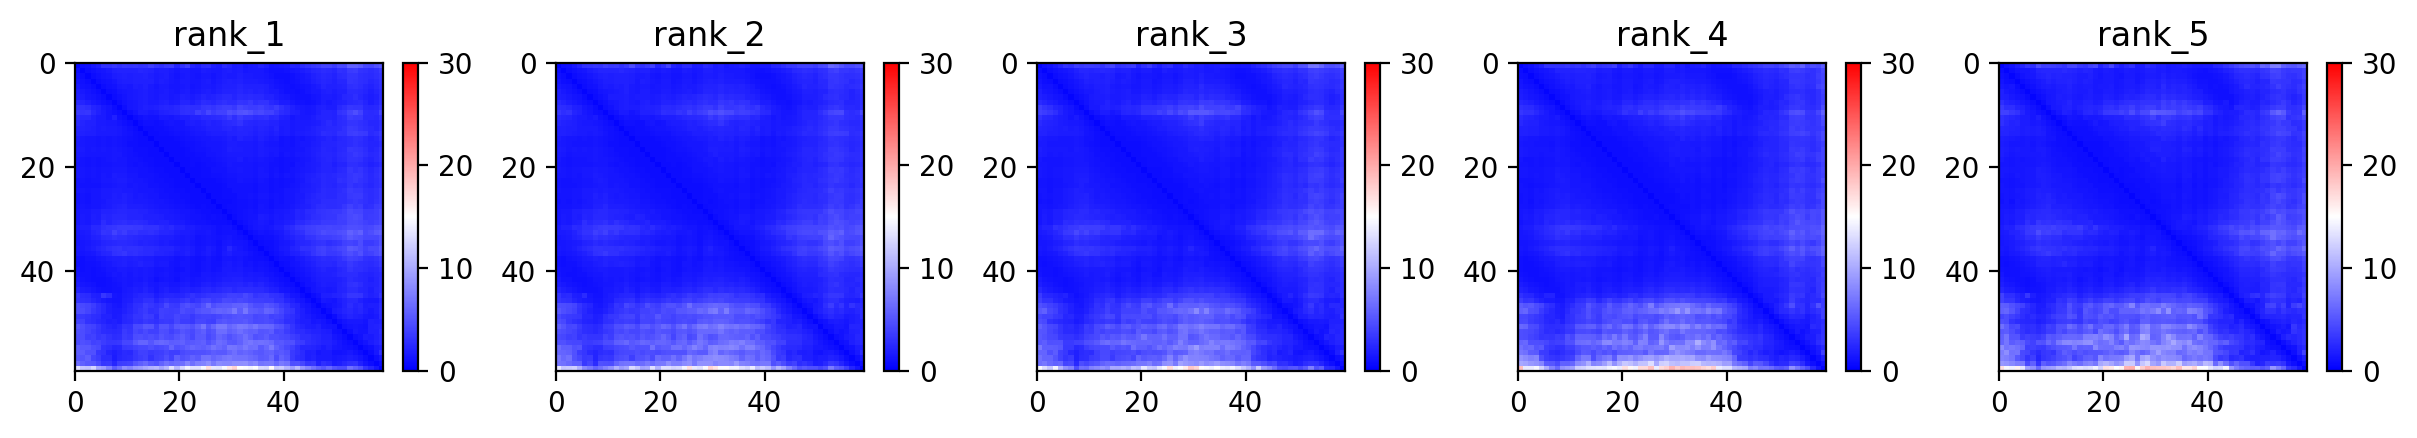
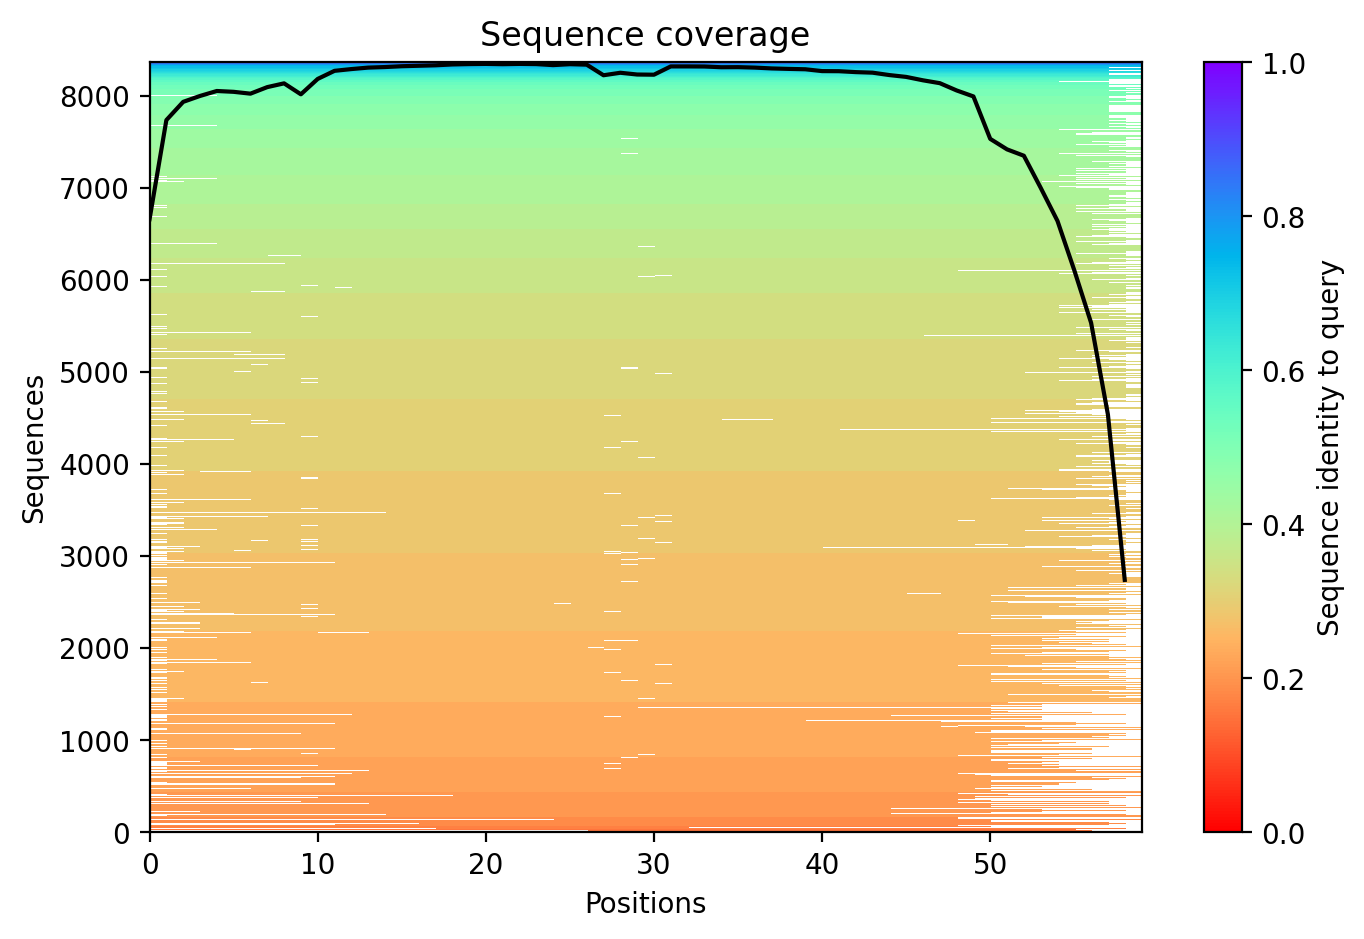
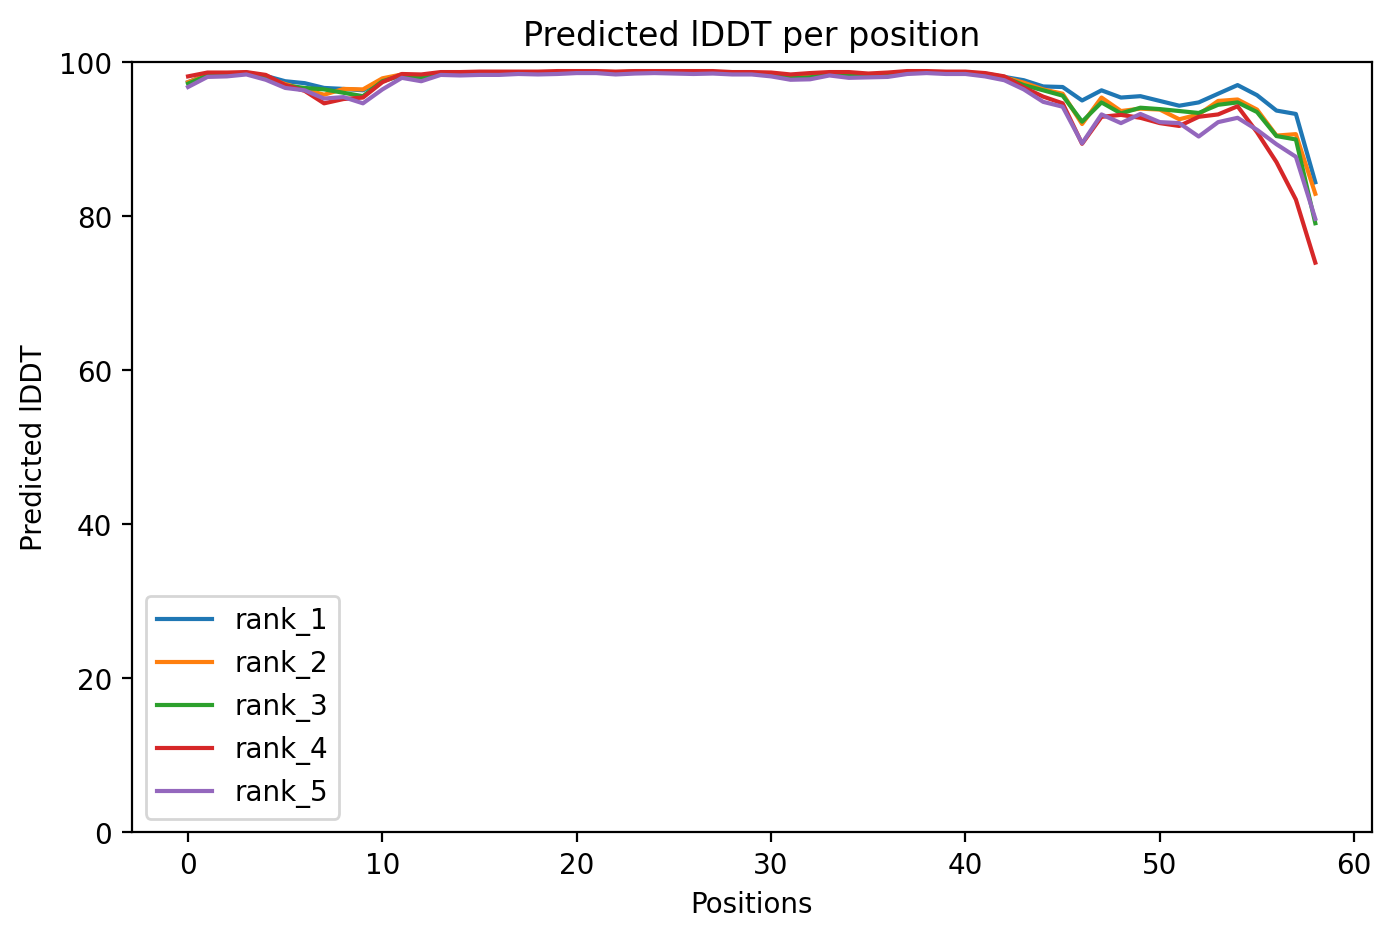

In [50]:
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
    ext = filename.split('.')[-1]
    prefix = f'data:image/{ext};base64,'
    with open(filename, 'rb') as f:
        img = f.read()
    return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png"></img><br>  

**ColabFold v1.5.2-patch: AlphaFold2 using MMseqs2**  
Easy-to-use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see [bottom](#Instructions) of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read the authors' manuscript: [Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1).
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb)

**LICENSE**  
The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).  

**PDB100**   
As of 23/06/08, ColabFold has transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.  
The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/).  
On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).  
*To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.*  

**USING CUSTOM TEMPLATES**  
\- Custom templates must follow the four letter PDB naming with lower case letters.  
\- Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.  
\- Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.  
\- If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**COMPARISON TO THE FULL ALPHAFOLD2 AND ALPHAFOLD2 COLAB**  
This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**BUGS**  
If you encounter any bugs in the original notebook, please report the issue to https://github.com/sokrypton/ColabFold/issues

**LIMITATIONS**  
*The ColabFold's authors recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).*  
\- **Computing resources:** The original [ColabFold AlphaFold2 notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) MMseqs2 API can handle ~20-50k requests per day.  
\- **MSAs:** MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.

**DESCRIPTION OF PLOTS**  
\- **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.  
\- **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.  
\- **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.  

**COLABFOLD ACKNOWLEDGEMENTS**  
\- We thank the AlphaFold team for developing an excellent model and open sourcing the software.  
\- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.  
\- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.  
\- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!  
\- Do-Yoon Kim for creating the ColabFold logo.  
\- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).